In [1]:
import numpy as np
import h5py
from scipy.ndimage import zoom, laplace, gaussian_filter, rotate
from scipy.interpolate import RegularGridInterpolator as RGI
from scipy.interpolate import splprep, splev
import matplotlib.pyplot as plt
from matplotlib.path import Path
import os
from tqdm import tqdm
import json
import traceback
import pydicom
import pickle
import datetime
import copy
import csv
import pandas as pd
import multiprocessing as mp
import gc
# Test if gdcm works for decompressing JPEG 2000
print("IT IS {}, GDCM IS LOCKED AND LOADED".format(pydicom.pixel_data_handlers.gdcm_handler.is_available()))

# import cv2
# from mpl_toolkits.mplot3d import Axes3D
# import matplotlib
# matplotlib.use('Agg')


IT IS True, GDCM IS LOCKED AND LOADED


In [2]:
PROJECTPATH = '/home/ayeluru/4d-flow-automation/'
DATAPATH = os.path.join(PROJECTPATH,'ge-testing')
ANNOPATH = os.path.join(PROJECTPATH, 'ge-testing')

MAGPATH = os.path.join(DATAPATH, 'ge-volumetric-cardiac-magdata.hdf5')
# COORDPATH = os.path.join(ANNOPATH, 'localizations_rcs_coords_19April2023.pkl')
SCALINGPATH = os.path.join(ANNOPATH, 'ge-localizations_rcs_scale_factors_040225.pkl')

In [5]:
# with open(COORDPATH, "rb") as file:
#     allcoords = pickle.load(file)
    
with open(SCALINGPATH, "rb") as file:
    allscales = pickle.load(file)
    
magdata = h5py.File(MAGPATH, 'r')

In [6]:
FLOWPATH = os.path.join(DATAPATH, 'ge-volumetric-cardiac-4dflow.hdf5')
METAPATH = os.path.join(DATAPATH,'ge-cardiac-4dflow-metadata.pkl')

with open(METAPATH, "rb") as metafile:
    allmeta = pickle.load(metafile)
flowdata = h5py.File(FLOWPATH, 'r')

In [13]:
OUTPATH_MAG = os.path.join(DATAPATH, 'ge-testing_locnet_img.hdf5')
# OUTPATH_LBL = os.path.join(DATAPATH, 'testing_locnet_lbl.hdf5')
OUTINFO = os.path.join(DATAPATH, 'ge-testing_locnet_info.pkl')

try:
    os.remove(OUTPATH_MAG)
    os.remove(OUTPATH_LBL)
    os.remove(OUTINFO)
except:
    pass

In [14]:
def _pat2inp(key):
    
    img = copy.deepcopy(np.array(magdata[key]))
    imgshp = list(img.shape)
    
    inpshp = (imgshp[3], imgshp[0], imgshp[1], imgshp[2], 1)
    inp = np.zeros(inpshp)

    for t in range(img.shape[3]):
        maxi = np.amax(img[...,t])
        mini = np.amin(img[...,t])
        inp[t,...,0] = (img[...,t]-mini)/(maxi-mini)
        
    return inp

def _inp2lbl(inp,key):
    lblshp = list(inp.shape)
    lblshp[-1] = 4
    lblshp = tuple(lblshp)
    lbl = np.zeros(lblshp)
    
    landmarks = ['AV', 'Ao', 'PV', 'PA']
    landex  = [0, 1, 2, 3]
    for i in landex:
        mark = landmarks[i]
        all_pts = allcoords[key][mark]
        
        for t in range(len(all_pts)):
            pt = all_pts[t]
            r,c,s = pt[0].astype(int), pt[1].astype(int), pt[2].astype(int)
            
            lbl[t,r,c,s,i] = 1
            lbl[t,...,i] = gaussian_filter(lbl[t,...,i],(5.5,5.5,1.5))
            maxi = np.amax(lbl[t,...,i])
            mini = np.amin(lbl[t,...,i])
            lbl[t,...,i] = _weight((lbl[t,...,i]-mini)/(maxi-mini))
            
    return lbl

def _weight(unweighted_data):
    weighted_data = 2*unweighted_data
    weighted_data[weighted_data>1] = 1
    
    return weighted_data
            

In [9]:
allmeta.keys()

dict_keys(['Gifice', 'Finkebet', 'Bibipnox', 'Tabipa', 'Flopika', 'Dicibi', 'Hopitat', 'Jugesag', 'Nuebafru', 'Cakimtol', 'Quakitu', 'Nesescet', 'Quequeri', 'Quisculjug', 'Petafi', 'Nosaybos'])

In [16]:
dim1, dim2, dim3 = 192,192,64
num_ch = 4

info_dict = dict()

try:
    outmag = h5py.File(OUTPATH_MAG, 'a')
#     outlbl = h5py.File(OUTPATH_LBL, 'a')
    for key in tqdm(list(magdata.keys())):
        inp = _pat2inp(key)
#         lbl = _inp2lbl(inp,key)

        curr_dict = {'metadata': allmeta[key], 'scales': allscales[key]}#, 'coordinates': allcoords[key]}
        info_dict[key] = curr_dict
        
        if not key in outmag:
            outmag.create_dataset(key, data=inp, compression='lzf', chunks=True,
                                 maxshape=(None,dim1,dim2,dim3,1))
#             outlbl.create_dataset(key,data=lbl, compression='lzf', chunks=True,
#                                  maxshape=(None,dim1,dim2,dim3,num_ch))
        
        print('Completed succesfully @ {}, [{}]'.format(key, outmag[key].shape))

#         print('Completed succesfully @ {}, [{} / {}]'.format(key, outmag[key].shape, outlbl[key].shape))
        
except:
    traceback.print_exc()
finally:
    outmag.close()
#     outlbl.close()
    with open(OUTINFO, 'wb') as f:
        pickle.dump(info_dict, f)

  6%|██████▍                                                                                               | 1/16 [00:01<00:19,  1.32s/it]

Completed succesfully @ Bibipnox, [(30, 192, 192, 64, 1)]


 12%|████████████▊                                                                                         | 2/16 [00:02<00:20,  1.47s/it]

Completed succesfully @ Cakimtol, [(20, 192, 192, 64, 1)]


 19%|███████████████████▏                                                                                  | 3/16 [00:05<00:23,  1.83s/it]

Completed succesfully @ Dicibi, [(30, 192, 192, 64, 1)]


 25%|█████████████████████████▌                                                                            | 4/16 [00:07<00:24,  2.06s/it]

Completed succesfully @ Finkebet, [(30, 192, 192, 64, 1)]


 31%|███████████████████████████████▉                                                                      | 5/16 [00:09<00:23,  2.17s/it]

Completed succesfully @ Flopika, [(30, 192, 192, 64, 1)]


 38%|██████████████████████████████████████▎                                                               | 6/16 [00:11<00:19,  1.94s/it]

Completed succesfully @ Gifice, [(20, 192, 192, 64, 1)]


 44%|████████████████████████████████████████████▋                                                         | 7/16 [00:12<00:16,  1.79s/it]

Completed succesfully @ Hopitat, [(20, 192, 192, 64, 1)]


 50%|███████████████████████████████████████████████████                                                   | 8/16 [00:14<00:13,  1.72s/it]

Completed succesfully @ Jugesag, [(20, 192, 192, 64, 1)]


 56%|█████████████████████████████████████████████████████████▍                                            | 9/16 [00:16<00:12,  1.75s/it]

Completed succesfully @ Nesescet, [(20, 192, 192, 64, 1)]


 62%|███████████████████████████████████████████████████████████████▏                                     | 10/16 [00:17<00:09,  1.65s/it]

Completed succesfully @ Nosaybos, [(20, 192, 192, 64, 1)]


 69%|█████████████████████████████████████████████████████████████████████▍                               | 11/16 [00:19<00:08,  1.61s/it]

Completed succesfully @ Nuebafru, [(20, 192, 192, 64, 1)]


 75%|███████████████████████████████████████████████████████████████████████████▊                         | 12/16 [00:20<00:06,  1.62s/it]

Completed succesfully @ Petafi, [(20, 192, 192, 64, 1)]


 81%|██████████████████████████████████████████████████████████████████████████████████                   | 13/16 [00:22<00:04,  1.61s/it]

Completed succesfully @ Quakitu, [(20, 192, 192, 64, 1)]


 88%|████████████████████████████████████████████████████████████████████████████████████████▍            | 14/16 [00:24<00:03,  1.60s/it]

Completed succesfully @ Quequeri, [(20, 192, 192, 64, 1)]


 94%|██████████████████████████████████████████████████████████████████████████████████████████████▋      | 15/16 [00:25<00:01,  1.67s/it]

Completed succesfully @ Quisculjug, [(20, 192, 192, 64, 1)]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:28<00:00,  1.77s/it]

Completed succesfully @ Tabipa, [(30, 192, 192, 64, 1)]


In [15]:
outmag = h5py.File(OUTPATH_MAG, 'a')
outlbl = h5py.File(OUTPATH_LBL, 'a')

In [28]:
outmag.close()
outlbl.close()

In [16]:
outlbl.keys()

<KeysViewHDF5 ['Besapol', 'Deefegi', 'Dehithu', 'Dukasa', 'Fegaygun', 'Fenoopub', 'Fratalooy', 'Gajefe', 'Giretap', 'Goxankot', 'Hetero', 'Hudutre', 'Jefoje', 'Kohugonk', 'Mifoyeg', 'Motale', 'Mozufuck', 'Narikag', 'Natotag', 'Noukumu', 'Nuebafru', 'Okiegop', 'Quiflula', 'Quisculjug', 'Repusug', 'Retasu', 'Sacureed', 'Scoostepip', 'Semagon', 'Sifaci', 'Tasnicu', 'Tesrenil', 'Tibomol', 'Tiheerien', 'Urquidash']>

<IPython.core.display.Javascript object>


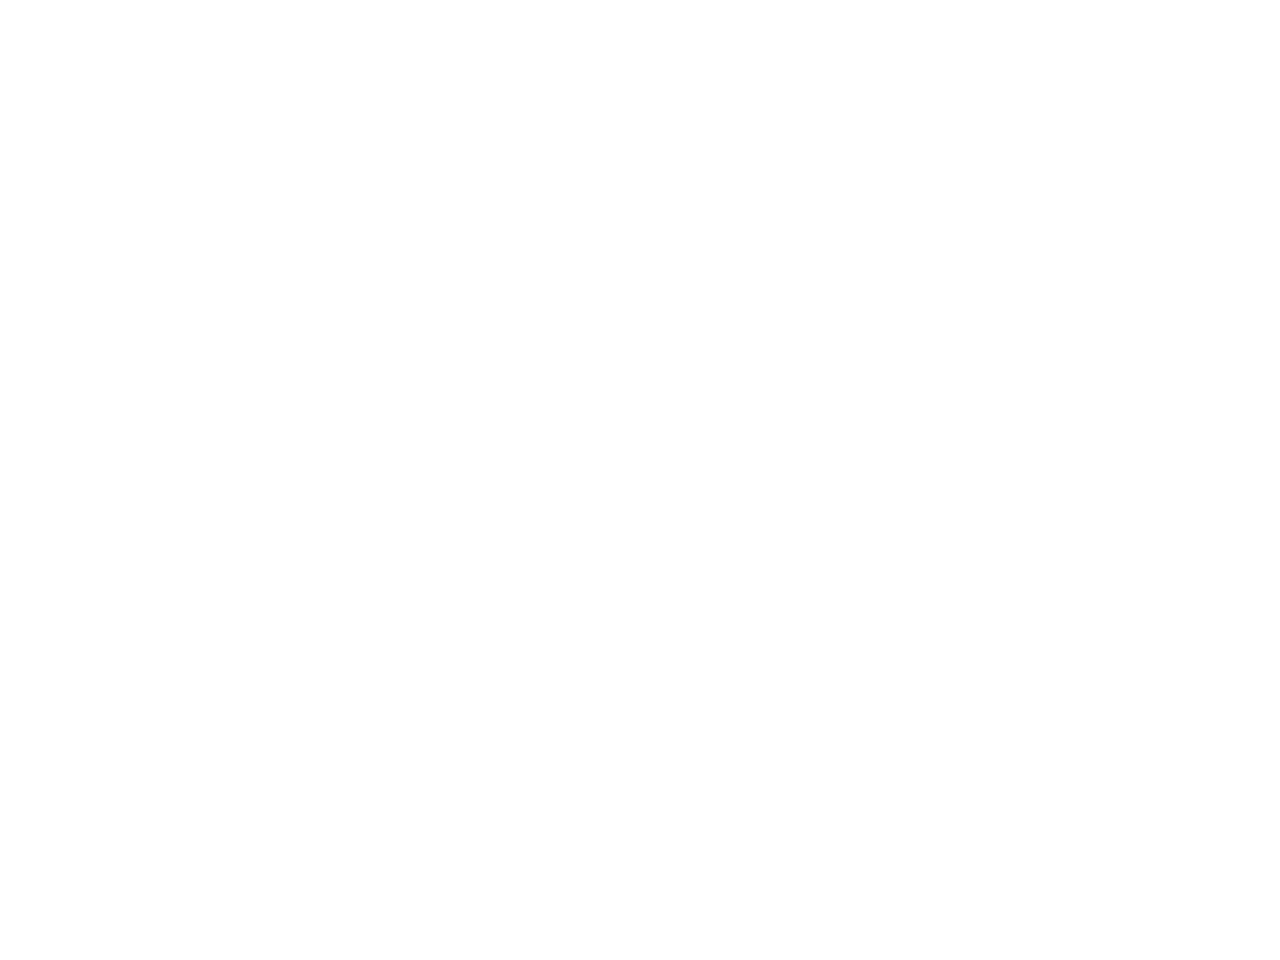

<IPython.core.display.Javascript object>


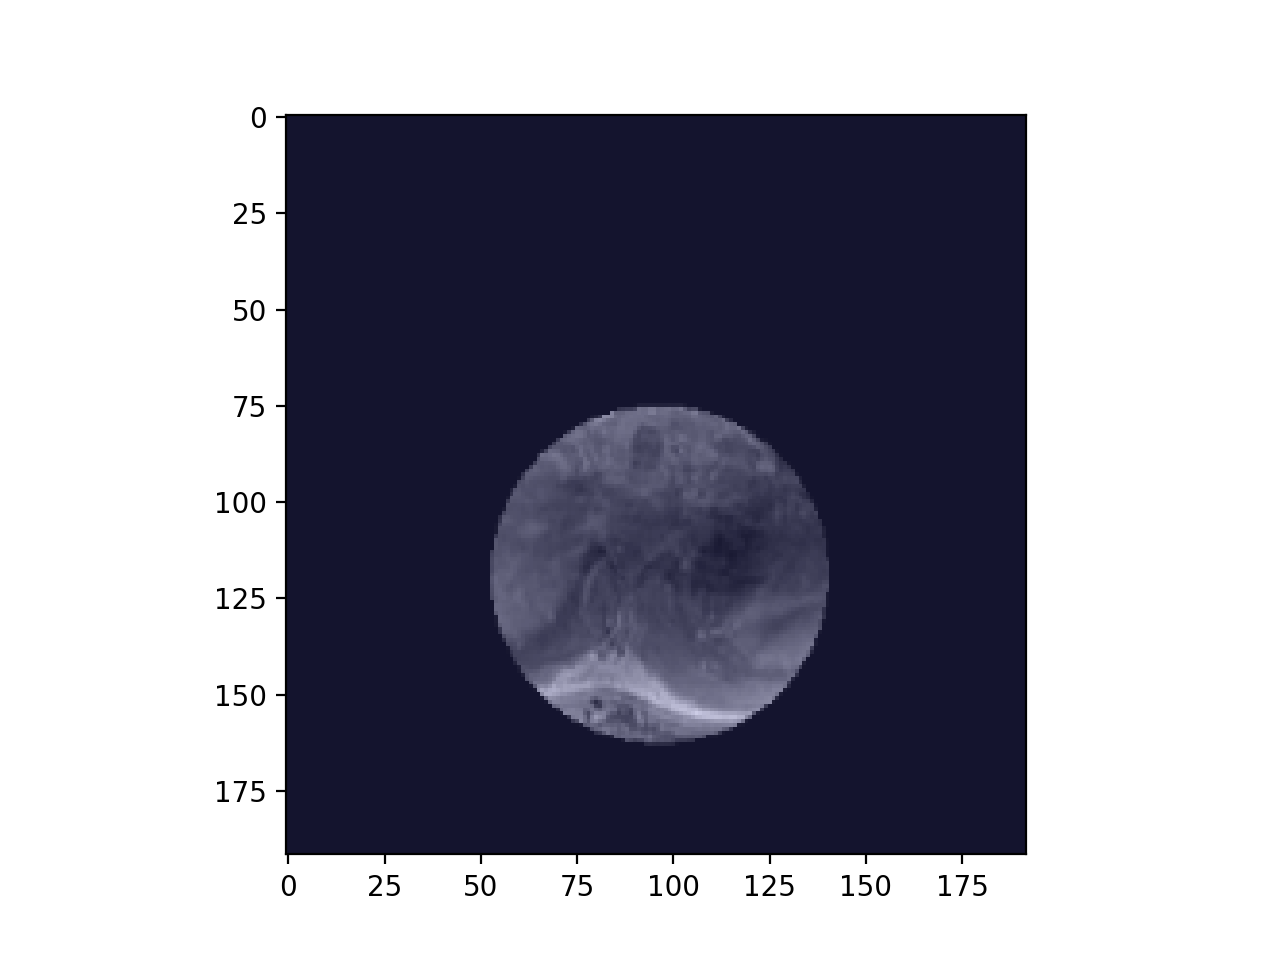

<IPython.core.display.Javascript object>


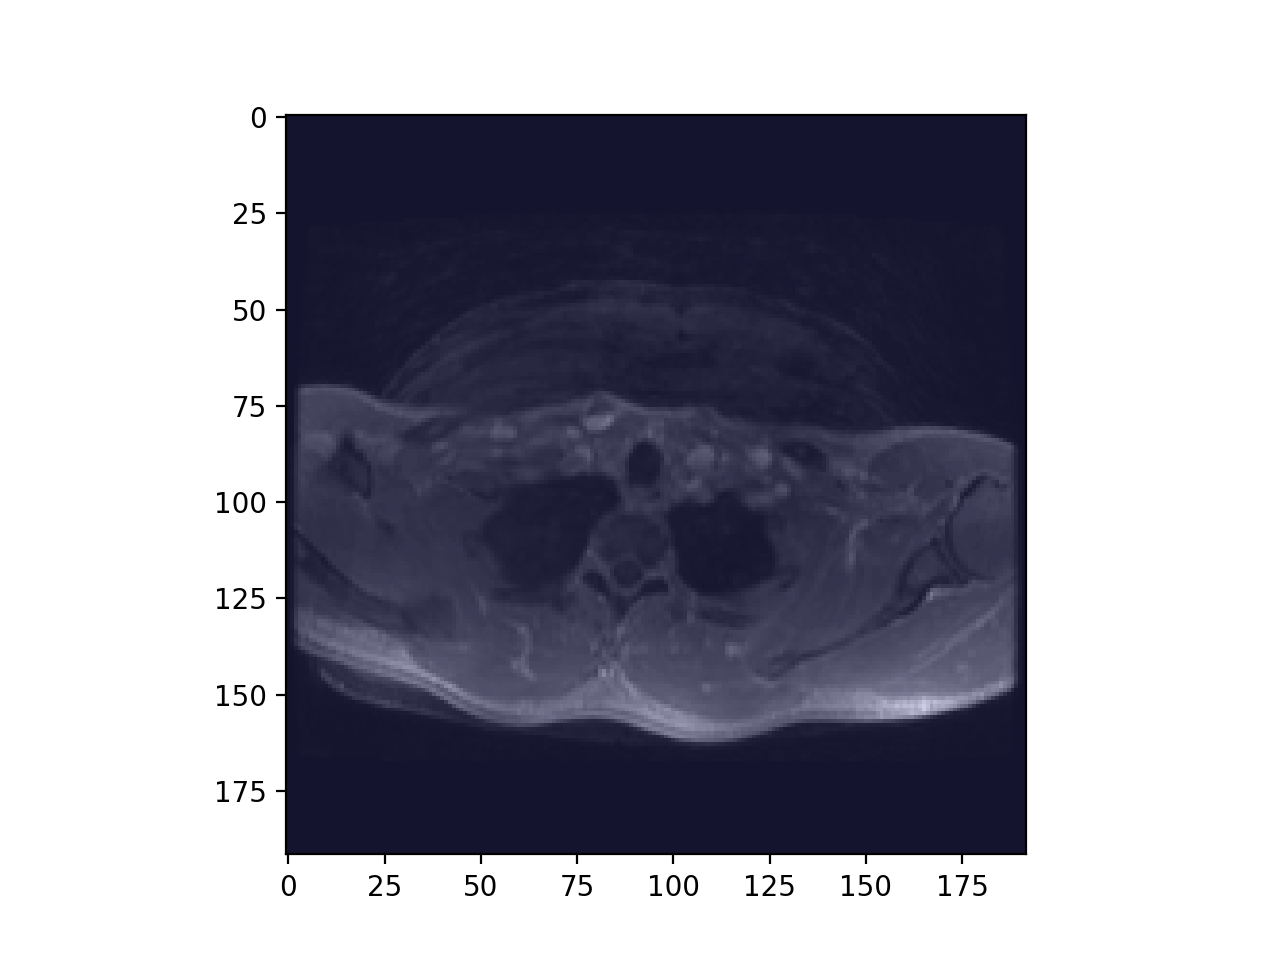

<IPython.core.display.Javascript object>


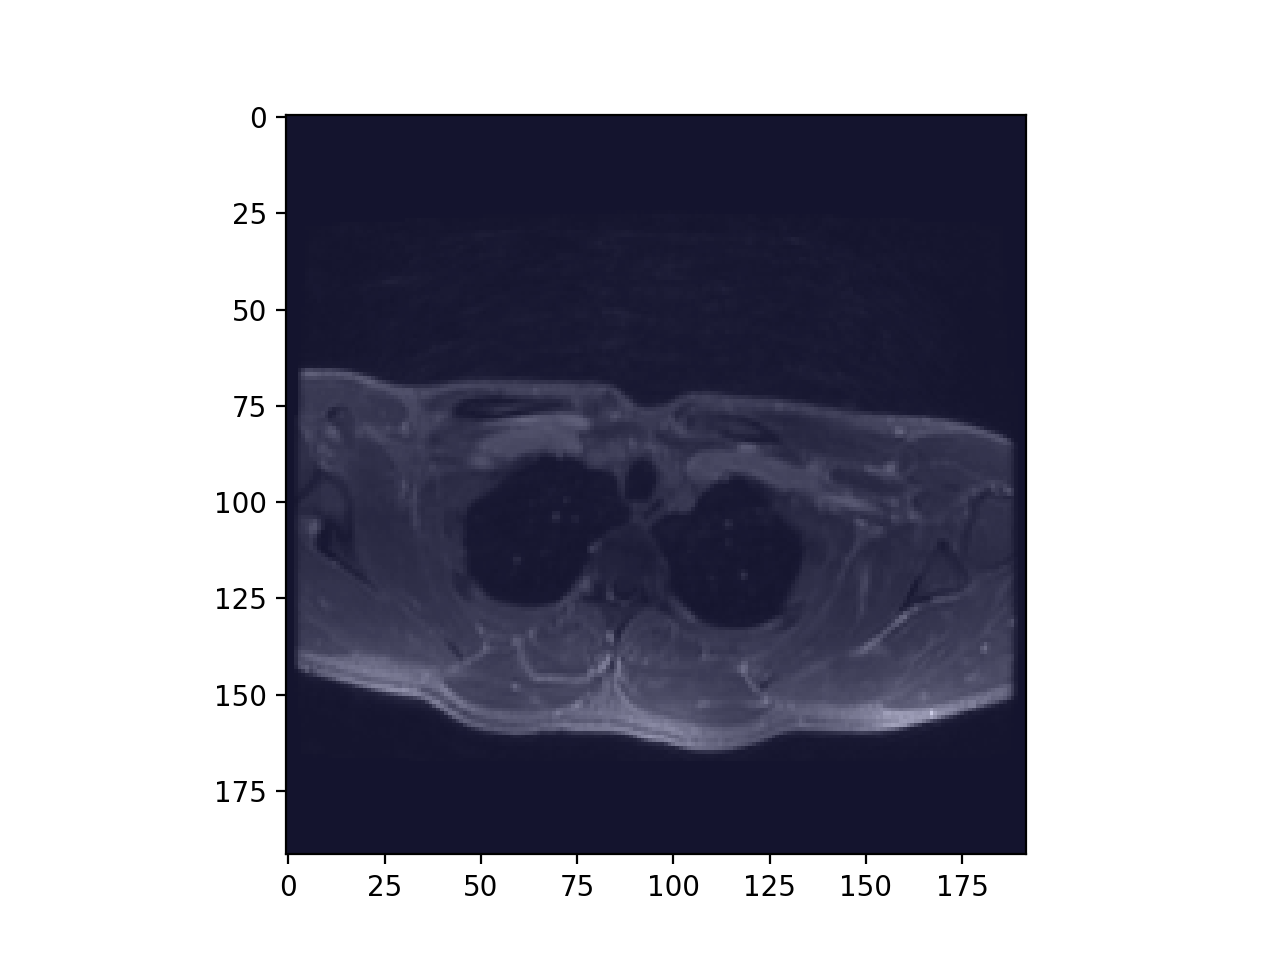

<IPython.core.display.Javascript object>


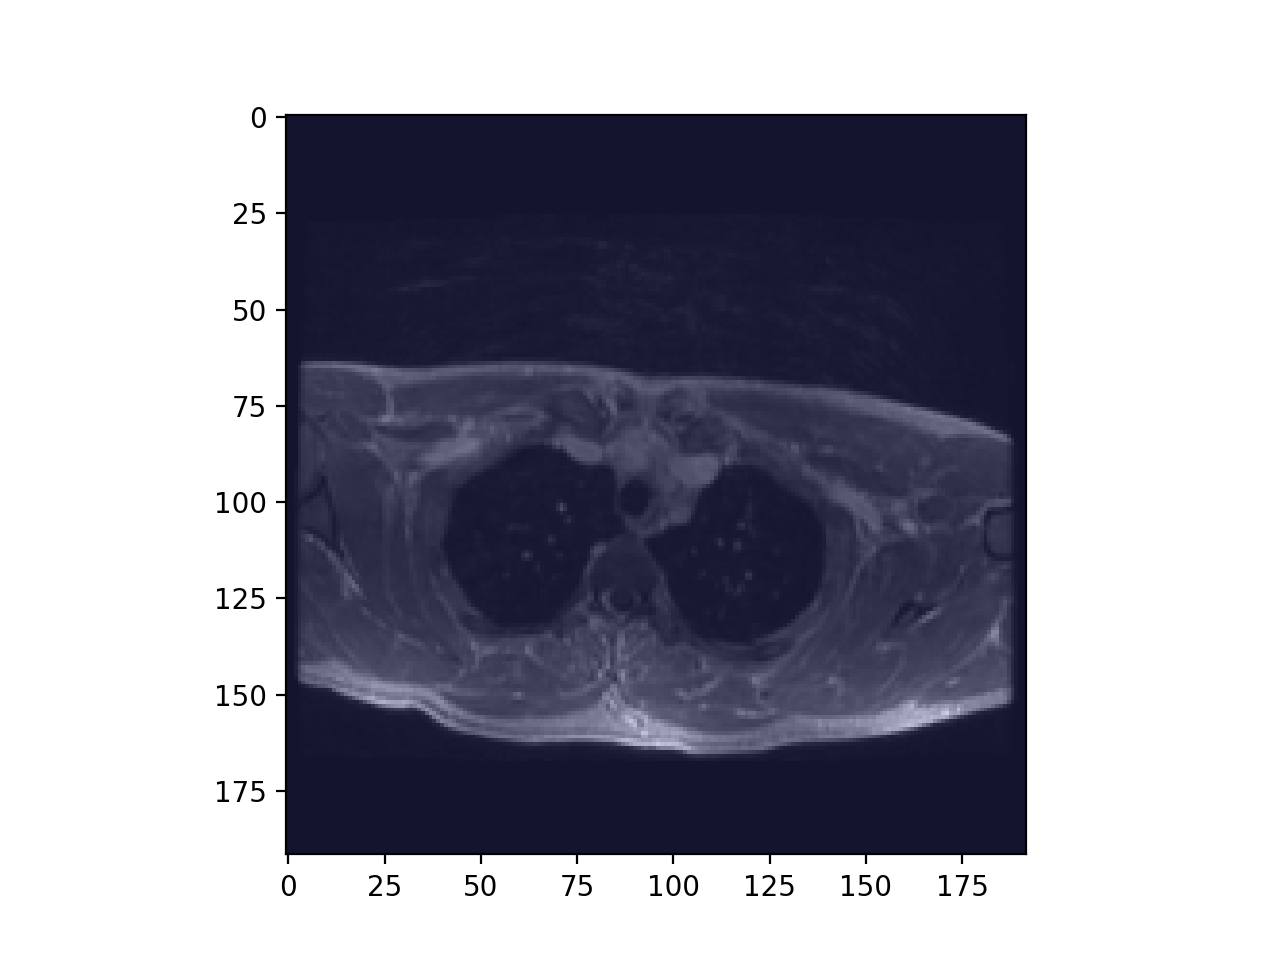

<IPython.core.display.Javascript object>


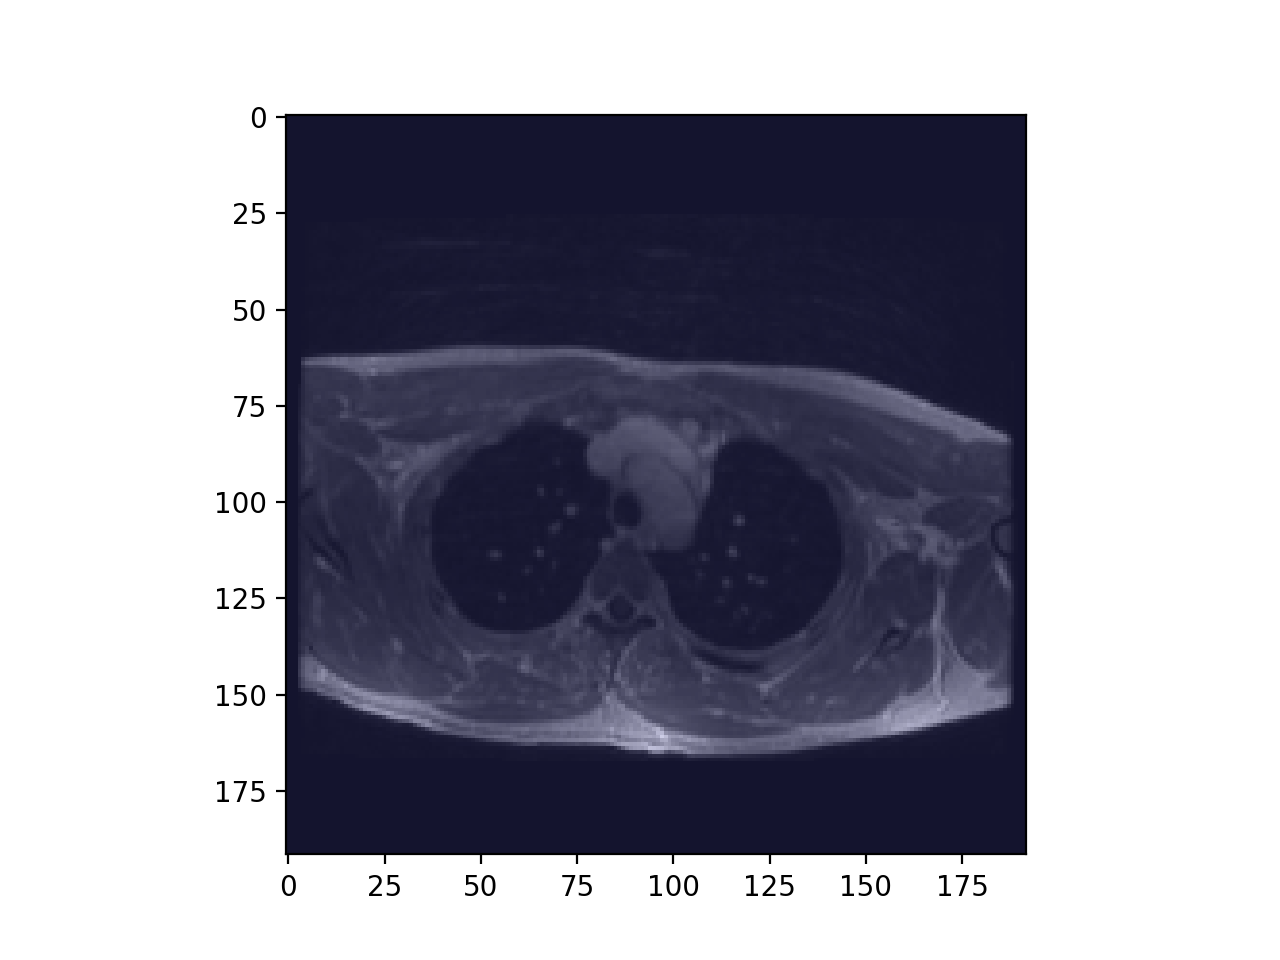

<IPython.core.display.Javascript object>


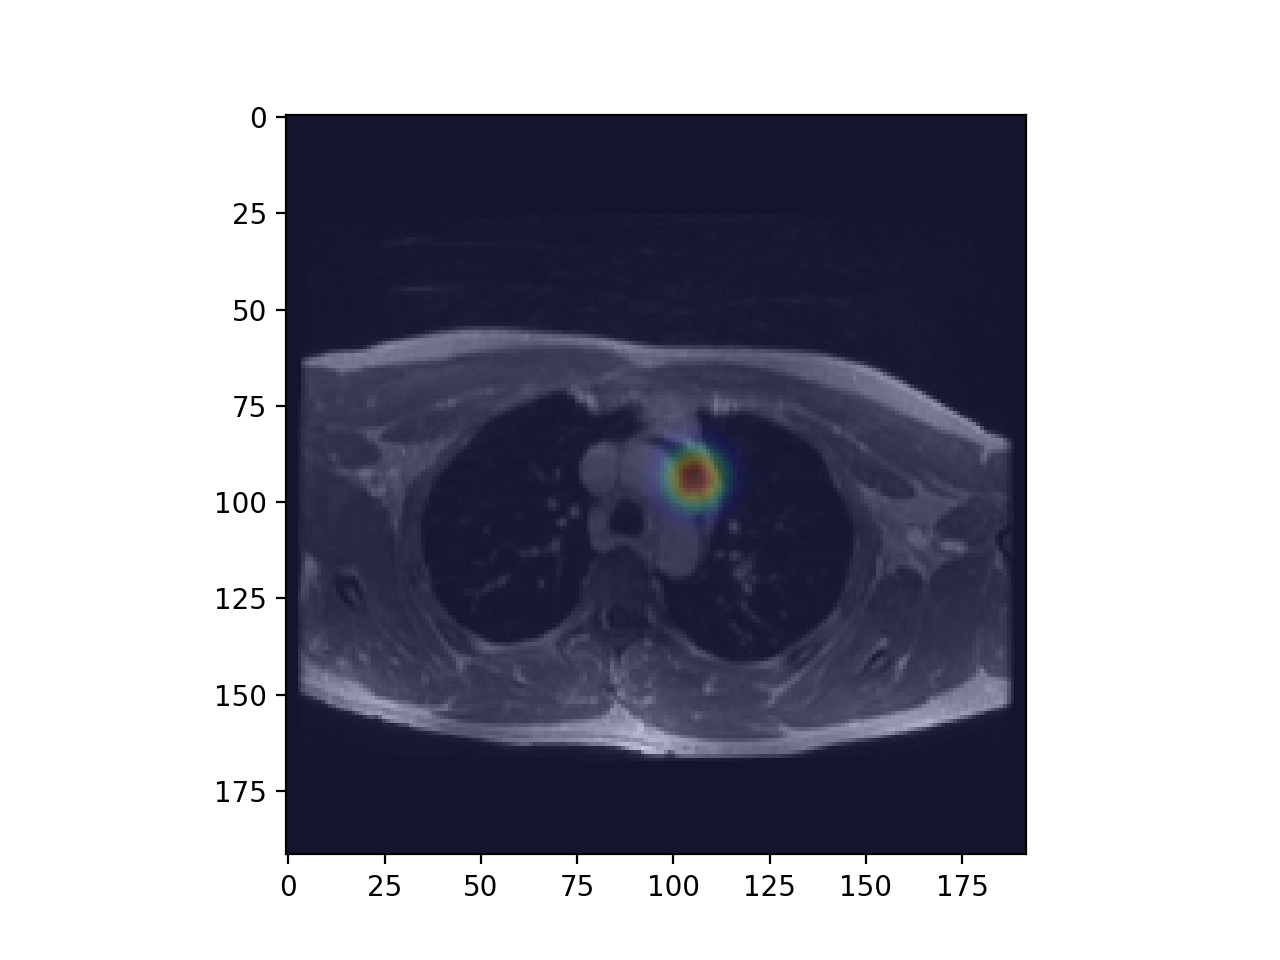

<IPython.core.display.Javascript object>


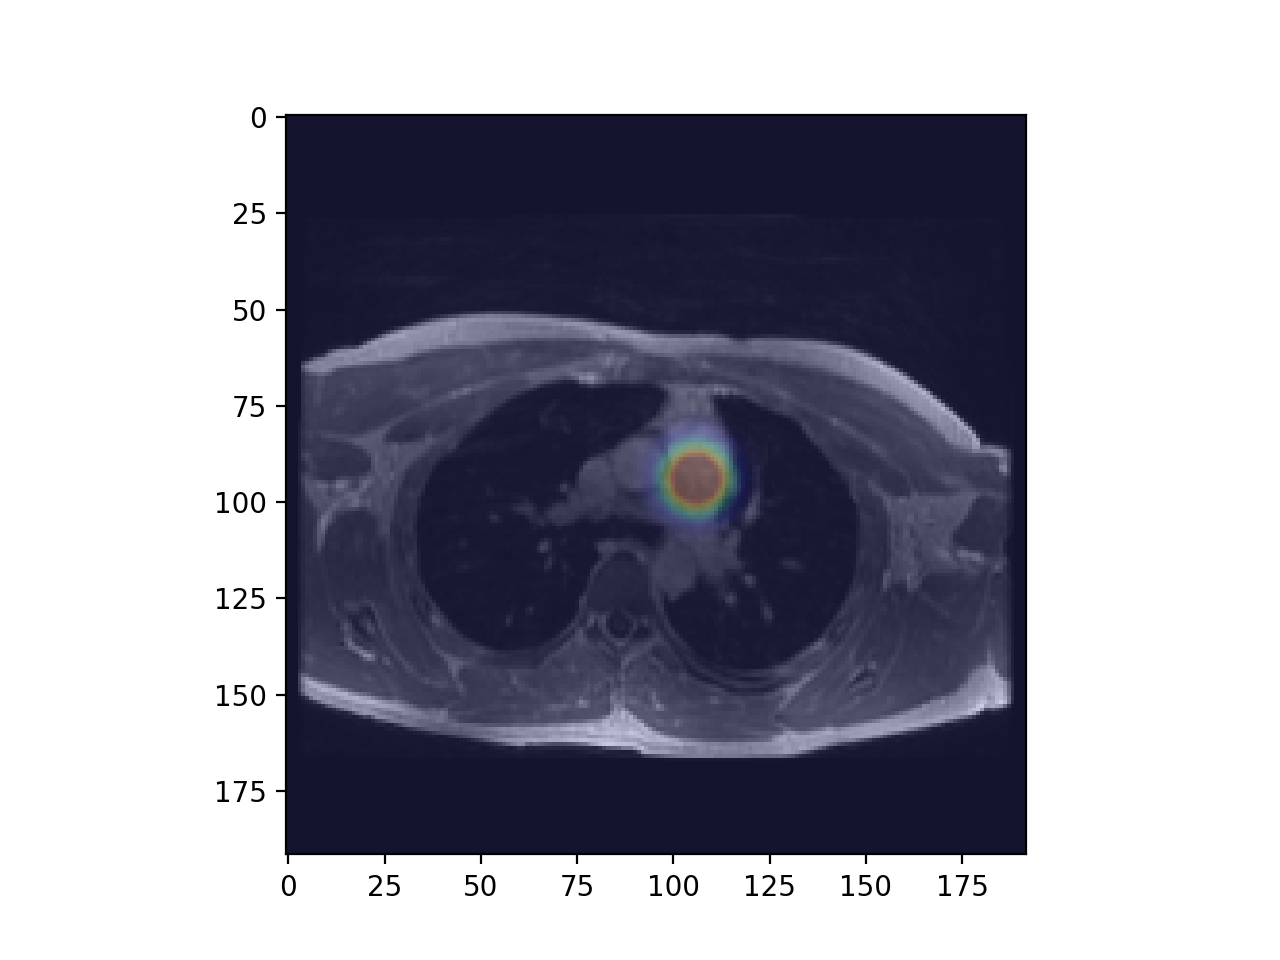

<IPython.core.display.Javascript object>


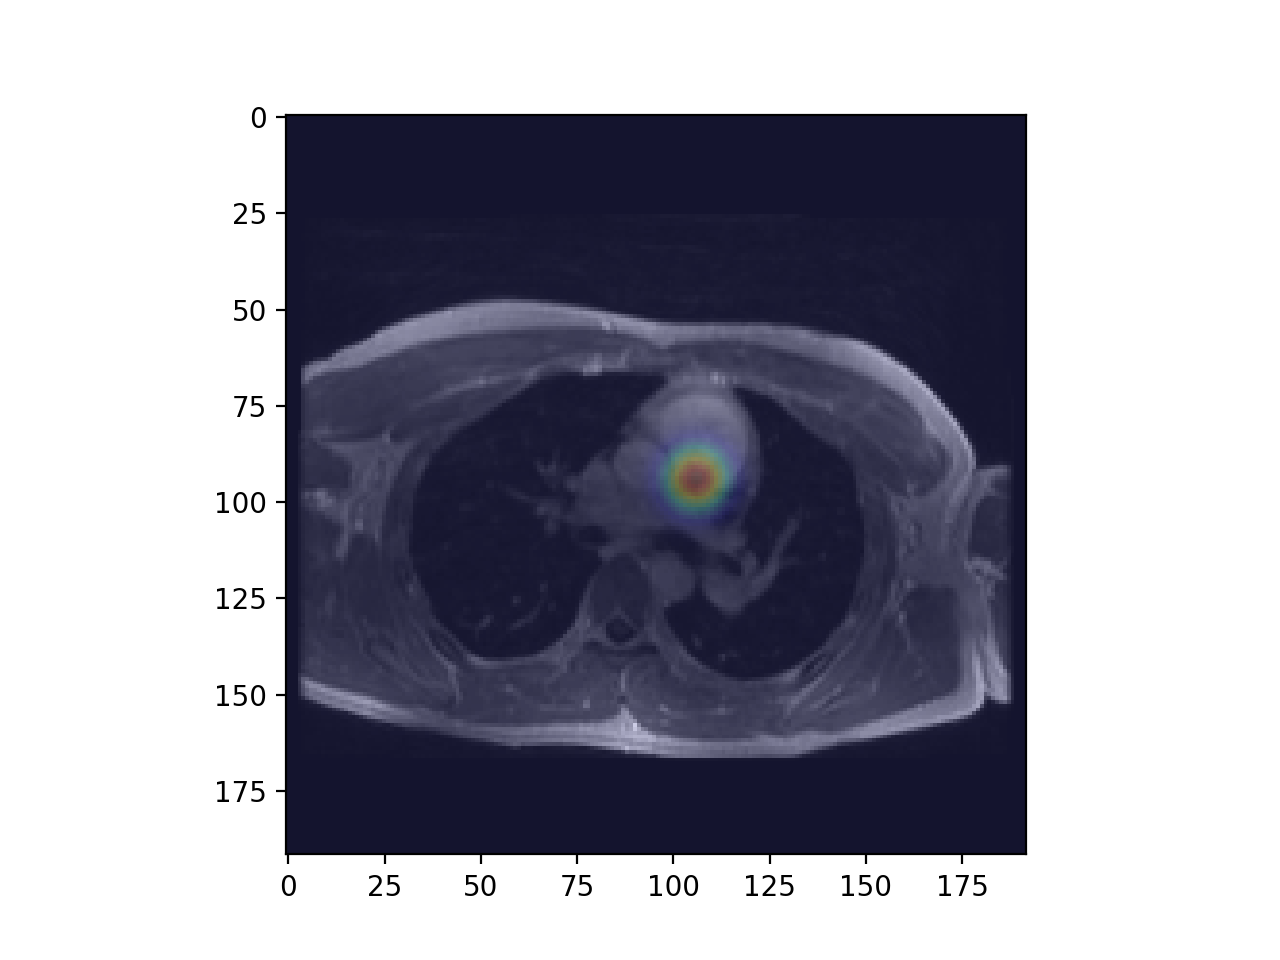

<IPython.core.display.Javascript object>


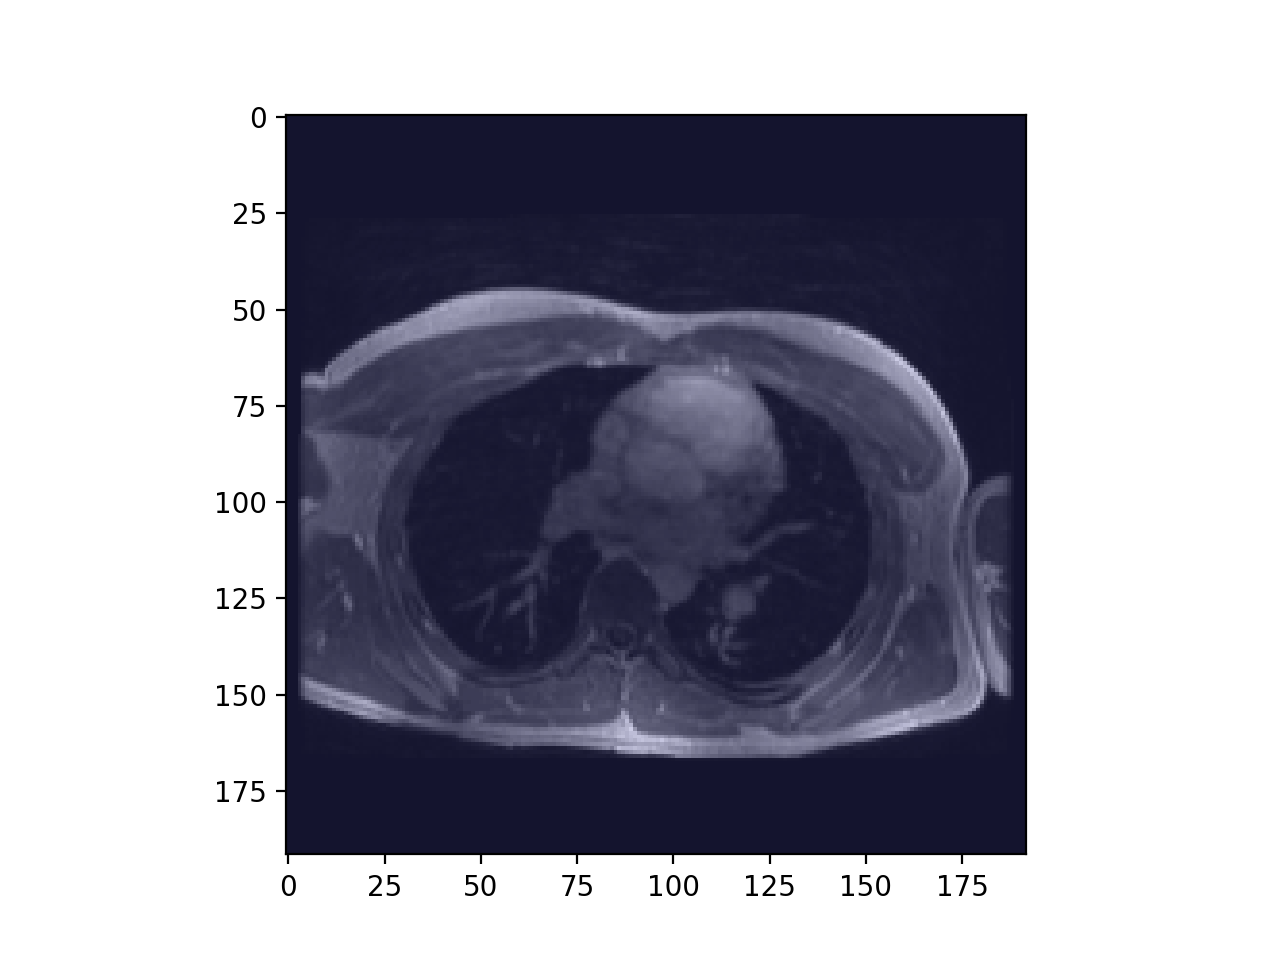

<IPython.core.display.Javascript object>


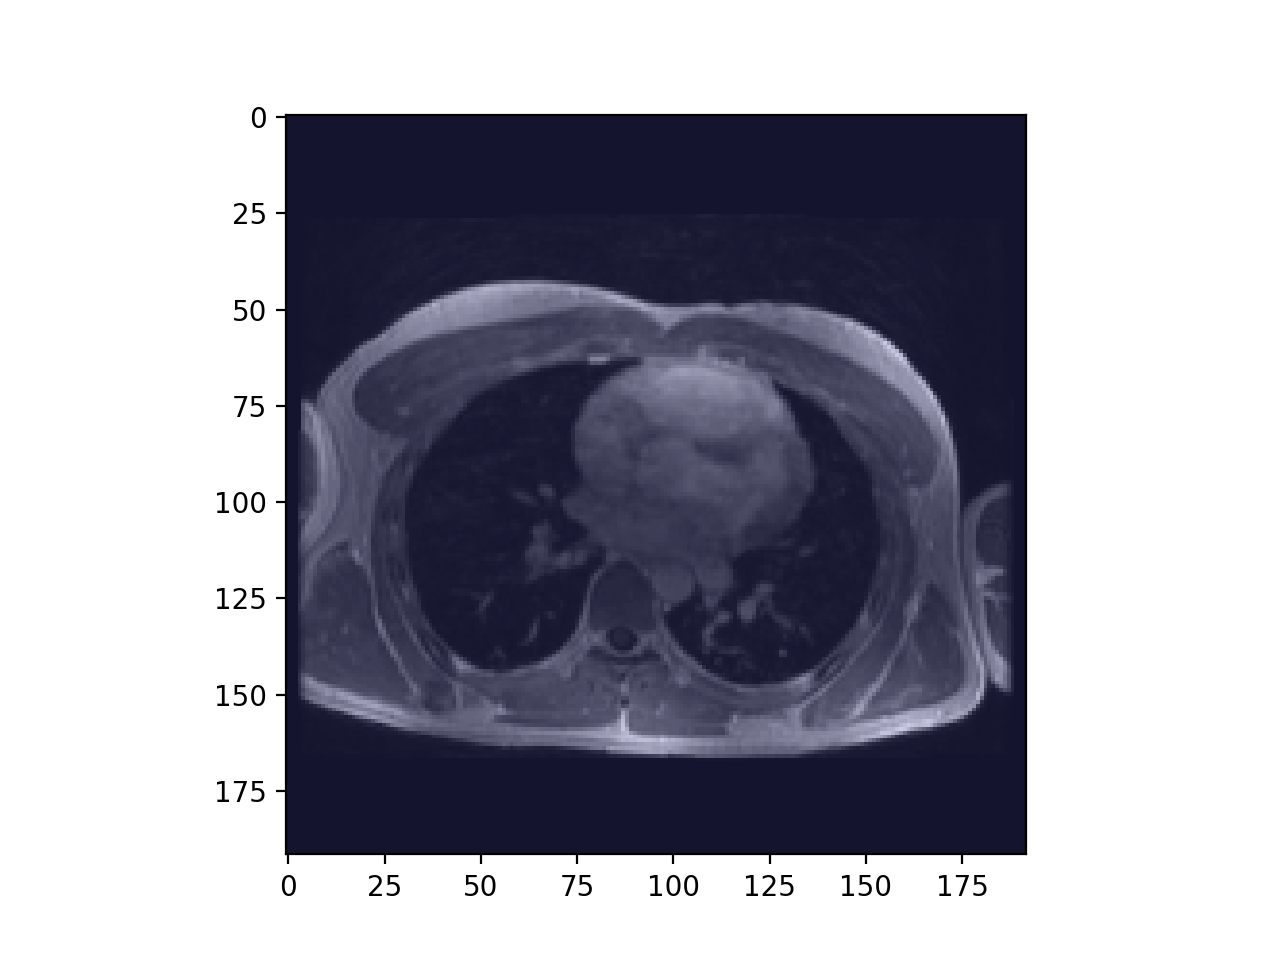

<IPython.core.display.Javascript object>


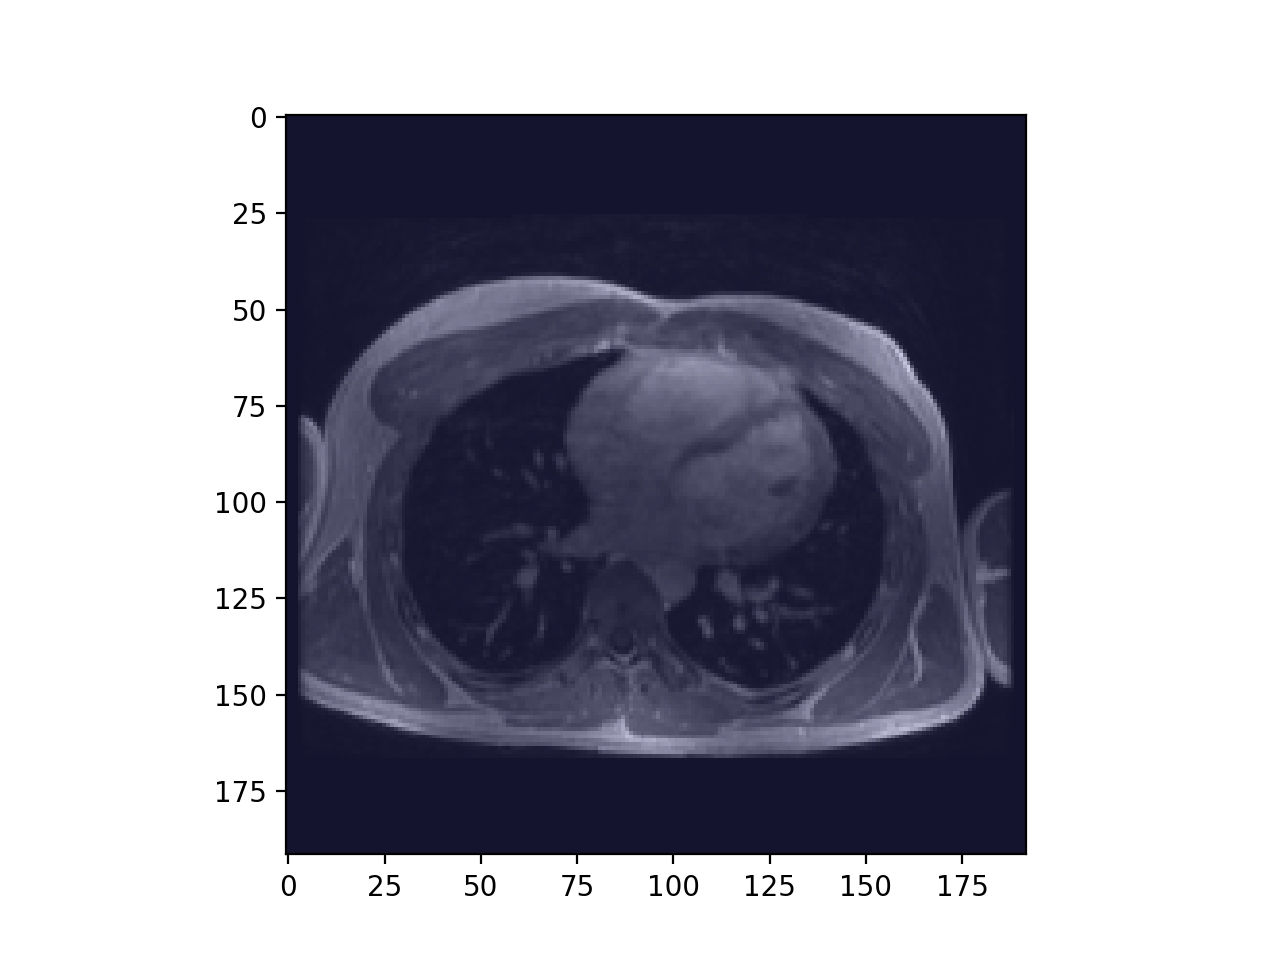

<IPython.core.display.Javascript object>


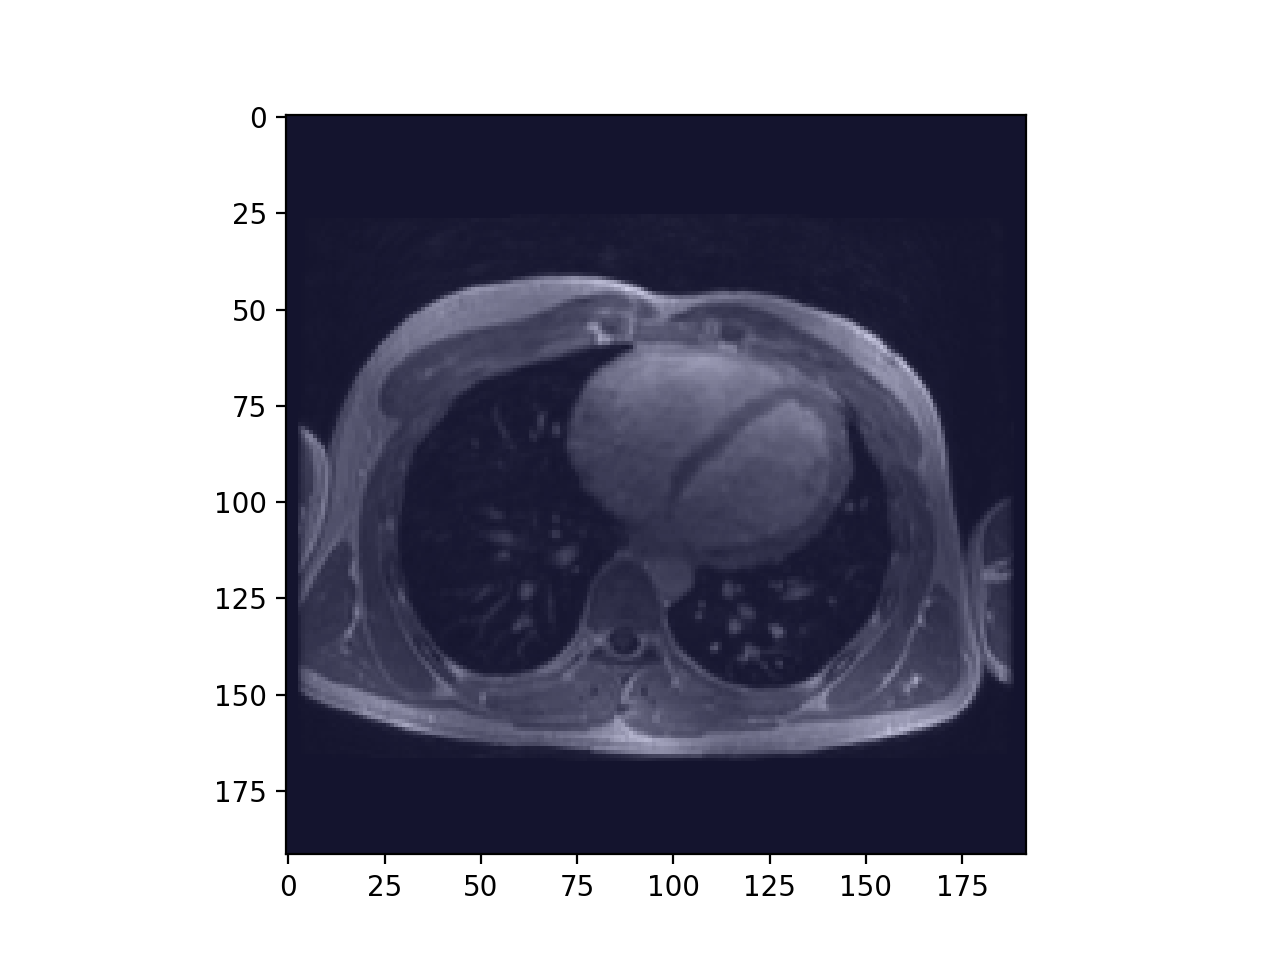

<IPython.core.display.Javascript object>


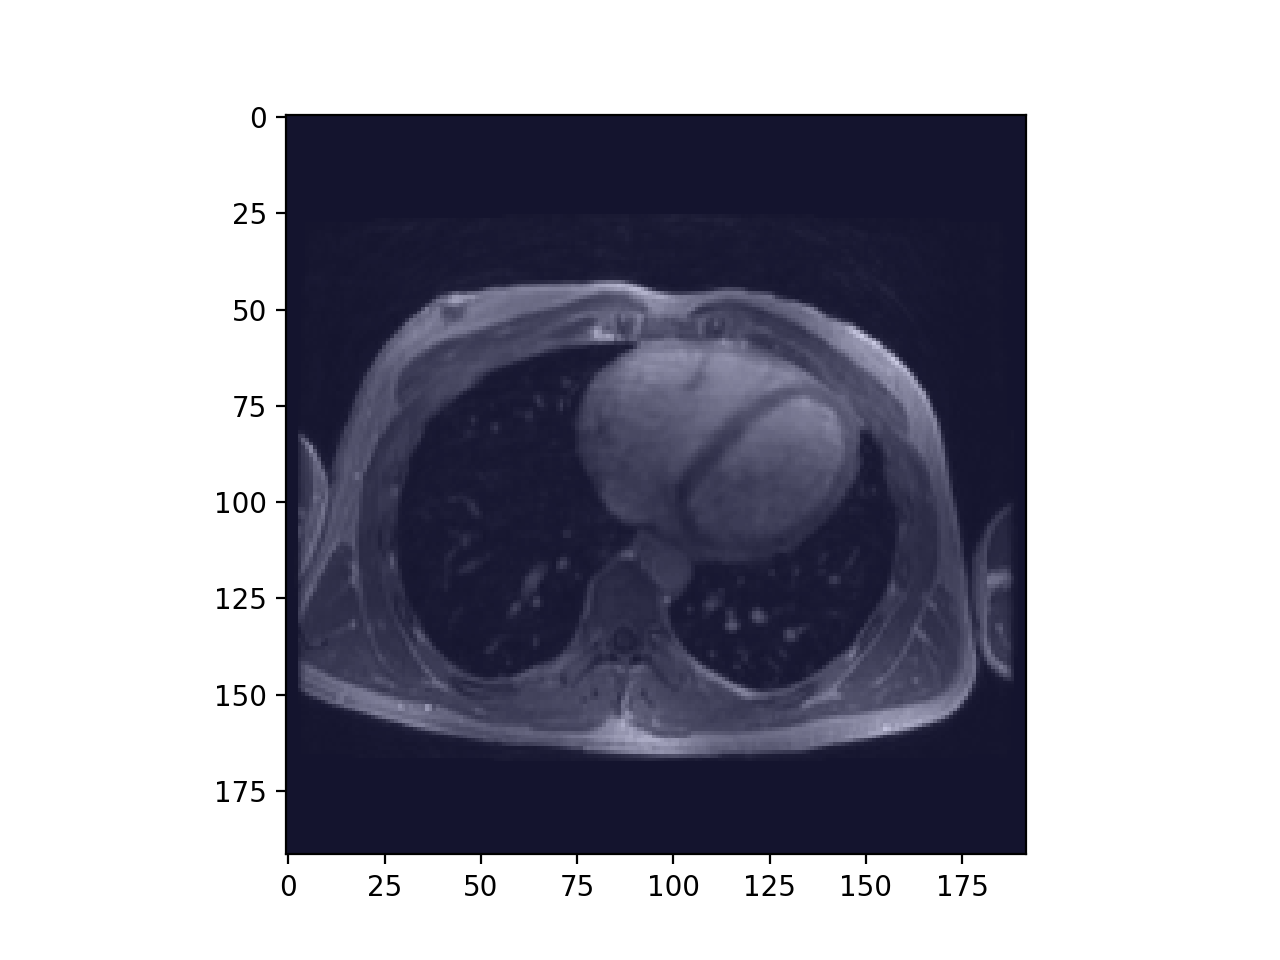

<IPython.core.display.Javascript object>


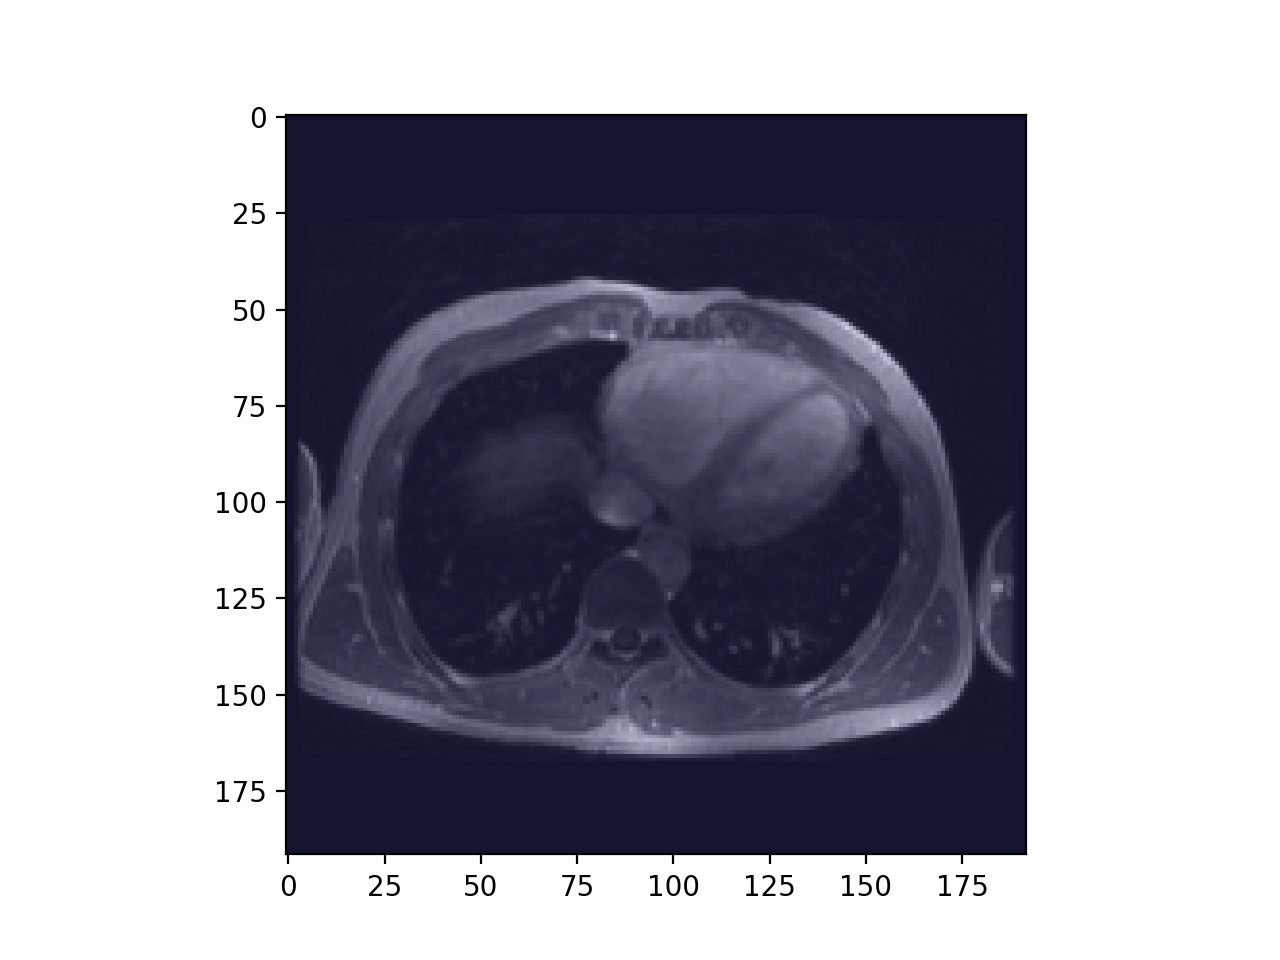

<IPython.core.display.Javascript object>


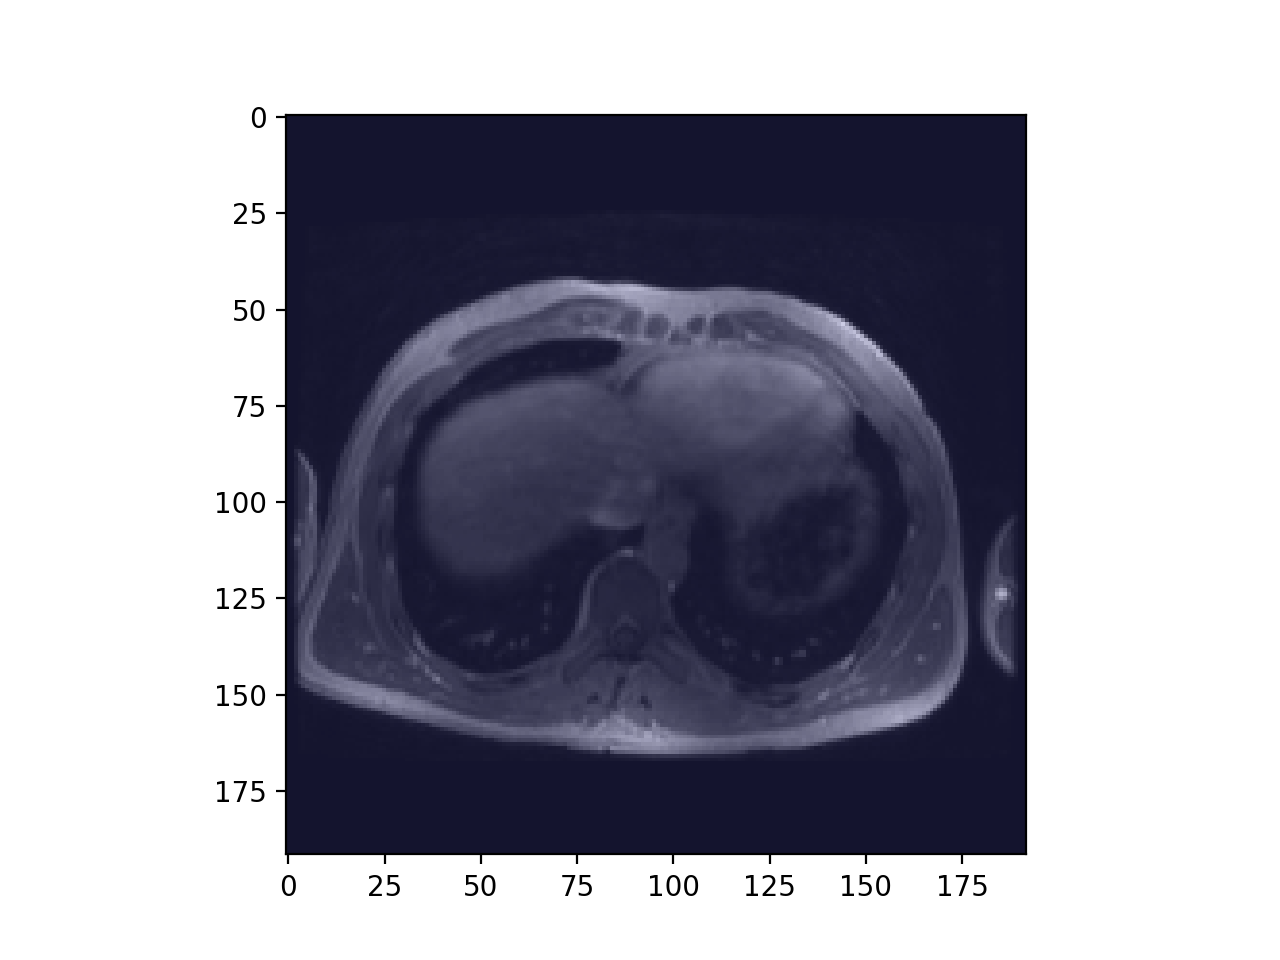

<IPython.core.display.Javascript object>


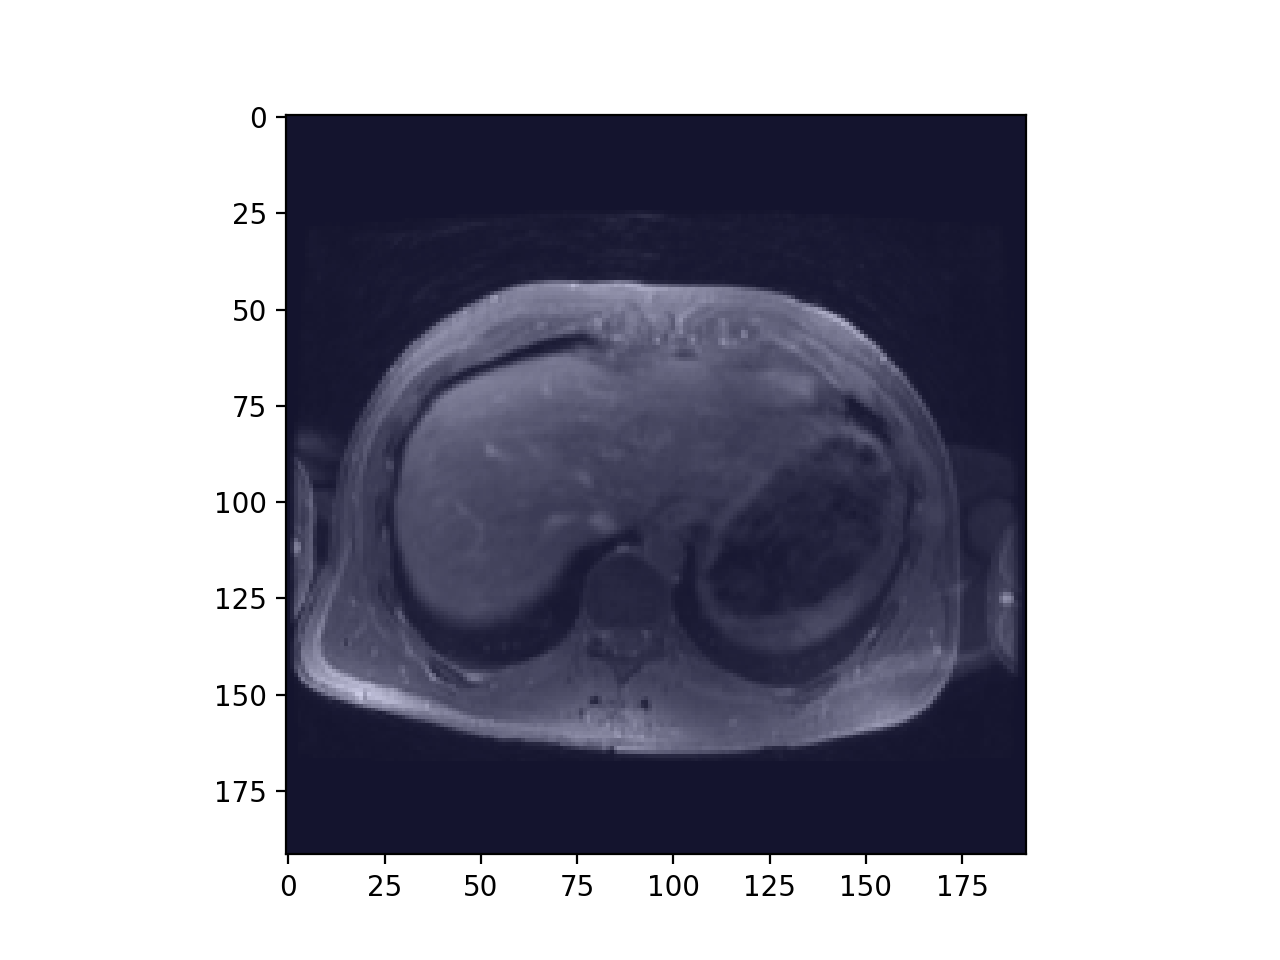

In [27]:
%matplotlib notebook

plt.figure()

for i in range(0,64,4):
    plt.figure()
    plt.imshow(outmag['Mifoyeg'][0,:,:,i,0], cmap='gray', alpha=0.9)
    plt.imshow(outlbl['Mifoyeg'][0,:,:,i,3], cmap='jet', alpha=0.2)



In [101]:
dim1, dim2, dim3 = 192,192,64
num_ch = 4

info_dict = []

try:
    output = h5py.File(OUTPATH, 'a')
    for key in tqdm(list(magdata.keys())):
        inp = _pat2inp(key)
        lbl = _inp2lbl(inp,key)

        curr_dict = {'pid': key, 'metadata': allmeta[key], 'scales': allscales[key], 'coordinates': allcoords[key]}
        for i in range(inp.shape[0]):
            info_dict.append(curr_dict)

        if not'inputs' in output:
            output.create_dataset('inputs', data=inp, compression='lzf', chunks=True,
                                  maxshape=(None,dim1,dim2,dim3,1))
            output.create_dataset('labels', data=lbl, compression='lzf', chunks=True,
                                 maxshape=(None,dim1, dim2, dim3, num_ch))
        else:
            output['inputs'].resize((output['inputs'].shape[0] + inp.shape[0]), axis=0)
            output['inputs'][-inp.shape[0]:] = inp

            output['labels'].resize((output['labels'].shape[0] + lbl.shape[0]), axis=0)
            output['labels'][-lbl.shape[0]:] = lbl
        
        print('Completed succesfully @ {}, [{} / {}]'.format(key, output['inputs'].shape, output['labels'].shape))
        
except:
    traceback.print_exc()
finally:
    output.close()
    with open(OUTINFO, 'wb') as f:
        pickle.dump(info_dict, f)

  3%|██▍                                                                                   | 1/35 [00:01<00:48,  1.42s/it]

Completed succesfully @ Besapol, [(20, 64, 64, 64, 1) / (20, 64, 64, 64, 4)]


  6%|████▉                                                                                 | 2/35 [00:02<00:49,  1.49s/it]

Completed succesfully @ Deefegi, [(40, 64, 64, 64, 1) / (40, 64, 64, 64, 4)]


  9%|███████▎                                                                              | 3/35 [00:04<00:47,  1.49s/it]

Completed succesfully @ Dehithu, [(60, 64, 64, 64, 1) / (60, 64, 64, 64, 4)]


 11%|█████████▊                                                                            | 4/35 [00:05<00:46,  1.49s/it]

Completed succesfully @ Dukasa, [(80, 64, 64, 64, 1) / (80, 64, 64, 64, 4)]


 14%|████████████▎                                                                         | 5/35 [00:07<00:44,  1.50s/it]

Completed succesfully @ Fegaygun, [(100, 64, 64, 64, 1) / (100, 64, 64, 64, 4)]


 17%|██████████████▋                                                                       | 6/35 [00:08<00:43,  1.50s/it]

Completed succesfully @ Fenoopub, [(120, 64, 64, 64, 1) / (120, 64, 64, 64, 4)]


 20%|█████████████████▏                                                                    | 7/35 [00:10<00:41,  1.48s/it]

Completed succesfully @ Fratalooy, [(140, 64, 64, 64, 1) / (140, 64, 64, 64, 4)]


 23%|███████████████████▋                                                                  | 8/35 [00:11<00:40,  1.50s/it]

Completed succesfully @ Gajefe, [(160, 64, 64, 64, 1) / (160, 64, 64, 64, 4)]


 26%|██████████████████████                                                                | 9/35 [00:13<00:39,  1.50s/it]

Completed succesfully @ Giretap, [(180, 64, 64, 64, 1) / (180, 64, 64, 64, 4)]


 29%|████████████████████████▎                                                            | 10/35 [00:14<00:37,  1.49s/it]

Completed succesfully @ Goxankot, [(200, 64, 64, 64, 1) / (200, 64, 64, 64, 4)]


 31%|██████████████████████████▋                                                          | 11/35 [00:16<00:36,  1.51s/it]

Completed succesfully @ Hetero, [(220, 64, 64, 64, 1) / (220, 64, 64, 64, 4)]


 34%|█████████████████████████████▏                                                       | 12/35 [00:17<00:34,  1.51s/it]

Completed succesfully @ Hudutre, [(240, 64, 64, 64, 1) / (240, 64, 64, 64, 4)]


 37%|███████████████████████████████▌                                                     | 13/35 [00:19<00:32,  1.50s/it]

Completed succesfully @ Jefoje, [(260, 64, 64, 64, 1) / (260, 64, 64, 64, 4)]


 40%|██████████████████████████████████                                                   | 14/35 [00:20<00:31,  1.51s/it]

Completed succesfully @ Kohugonk, [(280, 64, 64, 64, 1) / (280, 64, 64, 64, 4)]


 43%|████████████████████████████████████▍                                                | 15/35 [00:22<00:30,  1.52s/it]

Completed succesfully @ Mifoyeg, [(300, 64, 64, 64, 1) / (300, 64, 64, 64, 4)]


 46%|██████████████████████████████████████▊                                              | 16/35 [00:23<00:28,  1.50s/it]

Completed succesfully @ Motale, [(320, 64, 64, 64, 1) / (320, 64, 64, 64, 4)]


 49%|█████████████████████████████████████████▎                                           | 17/35 [00:25<00:27,  1.52s/it]

Completed succesfully @ Mozufuck, [(340, 64, 64, 64, 1) / (340, 64, 64, 64, 4)]


 51%|███████████████████████████████████████████▋                                         | 18/35 [00:27<00:25,  1.53s/it]

Completed succesfully @ Narikag, [(360, 64, 64, 64, 1) / (360, 64, 64, 64, 4)]


 54%|██████████████████████████████████████████████▏                                      | 19/35 [00:28<00:24,  1.52s/it]

Completed succesfully @ Natotag, [(380, 64, 64, 64, 1) / (380, 64, 64, 64, 4)]


 57%|████████████████████████████████████████████████▌                                    | 20/35 [00:30<00:23,  1.54s/it]

Completed succesfully @ Noukumu, [(400, 64, 64, 64, 1) / (400, 64, 64, 64, 4)]


 60%|███████████████████████████████████████████████████                                  | 21/35 [00:31<00:21,  1.55s/it]

Completed succesfully @ Nuebafru, [(420, 64, 64, 64, 1) / (420, 64, 64, 64, 4)]


 63%|█████████████████████████████████████████████████████▍                               | 22/35 [00:33<00:21,  1.67s/it]

Completed succesfully @ Okiegop, [(440, 64, 64, 64, 1) / (440, 64, 64, 64, 4)]


 66%|███████████████████████████████████████████████████████▊                             | 23/35 [00:35<00:19,  1.66s/it]

Completed succesfully @ Quiflula, [(460, 64, 64, 64, 1) / (460, 64, 64, 64, 4)]


 69%|██████████████████████████████████████████████████████████▎                          | 24/35 [00:36<00:18,  1.64s/it]

Completed succesfully @ Quisculjug, [(480, 64, 64, 64, 1) / (480, 64, 64, 64, 4)]


 71%|████████████████████████████████████████████████████████████▋                        | 25/35 [00:38<00:16,  1.62s/it]

Completed succesfully @ Repusug, [(500, 64, 64, 64, 1) / (500, 64, 64, 64, 4)]


 74%|███████████████████████████████████████████████████████████████▏                     | 26/35 [00:40<00:14,  1.64s/it]

Completed succesfully @ Retasu, [(520, 64, 64, 64, 1) / (520, 64, 64, 64, 4)]


 77%|█████████████████████████████████████████████████████████████████▌                   | 27/35 [00:41<00:13,  1.64s/it]

Completed succesfully @ Sacureed, [(540, 64, 64, 64, 1) / (540, 64, 64, 64, 4)]


 80%|████████████████████████████████████████████████████████████████████                 | 28/35 [00:43<00:11,  1.63s/it]

Completed succesfully @ Scoostepip, [(560, 64, 64, 64, 1) / (560, 64, 64, 64, 4)]


 83%|██████████████████████████████████████████████████████████████████████▍              | 29/35 [00:45<00:09,  1.66s/it]

Completed succesfully @ Semagon, [(580, 64, 64, 64, 1) / (580, 64, 64, 64, 4)]


 86%|████████████████████████████████████████████████████████████████████████▊            | 30/35 [00:46<00:08,  1.68s/it]

Completed succesfully @ Sifaci, [(600, 64, 64, 64, 1) / (600, 64, 64, 64, 4)]


 89%|███████████████████████████████████████████████████████████████████████████▎         | 31/35 [00:48<00:06,  1.68s/it]

Completed succesfully @ Tasnicu, [(620, 64, 64, 64, 1) / (620, 64, 64, 64, 4)]


 91%|█████████████████████████████████████████████████████████████████████████████▋       | 32/35 [00:50<00:05,  1.70s/it]

Completed succesfully @ Tesrenil, [(640, 64, 64, 64, 1) / (640, 64, 64, 64, 4)]


 94%|████████████████████████████████████████████████████████████████████████████████▏    | 33/35 [00:51<00:03,  1.69s/it]

Completed succesfully @ Tibomol, [(660, 64, 64, 64, 1) / (660, 64, 64, 64, 4)]


 97%|██████████████████████████████████████████████████████████████████████████████████▌  | 34/35 [00:53<00:01,  1.72s/it]

Completed succesfully @ Tiheerien, [(680, 64, 64, 64, 1) / (680, 64, 64, 64, 4)]


100%|█████████████████████████████████████████████████████████████████████████████████████| 35/35 [00:55<00:00,  1.59s/it]

Completed succesfully @ Urquidash, [(700, 64, 64, 64, 1) / (700, 64, 64, 64, 4)]
